In [52]:
from map_search import optimize_rot_trans, downsample_vol, symmetrize_ht3, grid_3d

In [53]:
from cryodrgn import mrcfile as mrc
vol1, _ = mrc.parse_mrc("../test_cases/cryosparc_P25_J411_008_volume_map.map")
vol2, _ = mrc.parse_mrc("../raw_maps_07072023/emd_27264.map")


In [54]:
import torch

vol1 = downsample_vol(torch.tensor(vol1), 0.64, target_res=5).cuda()
vol2 = downsample_vol(torch.tensor(vol2), 1.245, target_res=5).cuda()
print(vol1.shape)
print(vol2.shape)

torch.Size([128, 128, 128])
torch.Size([128, 128, 128])


In [55]:
from cryodrgn import lie_tools, so3_grid, utils
import numpy as np

quats1 = so3_grid.s2_grid_SO3(0).astype(np.float32)
rots1 = lie_tools.quaternions_to_SO3(torch.from_numpy(quats1)).cuda()

theta, phi = so3_grid.grid_s2(2)
psi = so3_grid.grid_s1(2)
quats2 = so3_grid.hopf_to_quat(
    np.repeat(theta, len(psi)),
    np.repeat(phi, len(psi)),
    np.tile(psi, len(theta)),
) 


allangs = torch.tensor(np.array([np.repeat(theta, len(psi)), np.repeat(phi, len(psi)), np.tile(psi, len(theta)),]))
rots2 = lie_tools.quaternions_to_SO3(torch.from_numpy(quats2)).cuda()
trans = None #torch.tensor(grid_3d(0,0,1)).cuda()

In [56]:
from cryodrgn.fft import htn_center, iht2_center

vol1_ht = symmetrize_ht3(htn_center(vol1 - vol1.mean()).unsqueeze(0))
vol2_ht = symmetrize_ht3(htn_center(vol2 - vol2.mean()).unsqueeze(0))

vol1_ht = htn_center(vol1 - vol1.mean()).unsqueeze(0)
vol2_ht = htn_center(vol2 - vol2.mean()).unsqueeze(0)
with torch.no_grad():
    corr, quer, tar = optimize_rot_trans(vol1_ht, vol2_ht, rots1, rots2, trans)
    #corr, quer, tar = optimize_rot_trans(vol1.unsqueeze(0), vol2.unsqueeze(0), rots1, rots2, trans)

q = quer.cpu().squeeze()
t = tar.cpu().squeeze()

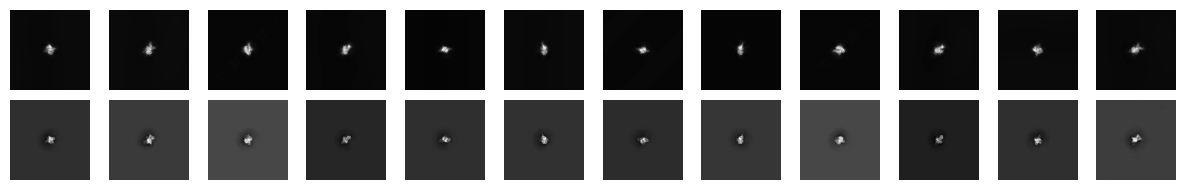

In [57]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def plot_projections(imgs, labels=None, max_imgs=1000, nrows=2):
    if len(imgs) > max_imgs:
        imgs = imgs[:max_imgs]

    N = len(imgs)
    ncols = N // nrows

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(ncols, nrows)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    if labels is None:
        labels = [None for _ in axes.ravel()]

    for img, ax, lbl in zip(imgs, axes.ravel(), labels):
        #ax.imshow(img, vmin=-15, vmax=15,cmap="Greys_r")
        ax.imshow(img,cmap="Greys_r")
        if lbl is not None:
            ax.set_title(lbl)
        ax.axis("off")

    plt.tight_layout()
    return fig, axes


plot_projections(iht2_center(torch.cat([q[...,:-1,:-1], t[...,:-1,:-1]])), nrows=2)
#plot_projections(torch.cat([q, t]))

plt.show()

In [58]:
((t - t.mean(dim=(-1,-2), keepdim=True)) * (q - q.mean(dim=(-1,-2), keepdim=True)) /  t.std(dim=(-1,-2), keepdim=True) / q.std(dim=(-1,-2), keepdim=True)).mean(dim=(-1,-2)) 

tensor([0.6842, 0.7120, 0.7035, 0.7265, 0.7936, 0.7759, 0.7936, 0.7759, 0.7035,
        0.7265, 0.6842, 0.7120])

In [59]:
import math
print(corr.max())
print(corr.min())

tensor(0.7352, device='cuda:0')
tensor(0.5643, device='cuda:0')


In [60]:
br_corr, bestrots = corr.max(dim=-1)
_, besttrans = torch.max(br_corr, dim=-1)
bestrot = bestrots.gather(-1, besttrans.unsqueeze(-1))

In [61]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Create a Rotation object from the matrix
rotation = R.from_matrix(rots2[bestrot.squeeze()].cpu().numpy())

# Get Euler angles in 'xyz' order (roll, pitch, yaw) in degrees
euler_angles = rotation.as_euler('xyz', degrees=True)
print(euler_angles)

[  8.34232944  -8.25528114 -38.10308944]


In [62]:
bestrot

tensor([[[4239]]], device='cuda:0')

In [63]:
allangs.shape

torch.Size([3, 4608])

In [64]:
corr.isnan().sum()

tensor(0, device='cuda:0')